In [3]:
# Importing necessary libraries
import torch, torchvision
from torch import nn
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

In [4]:
# set up random generator seed
torch.manual_seed(42)

In [6]:
# models need to be more complex (larger amounts of parameters) --> Use CUDA as device (if available)
device = ""

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [7]:
# Preparing training data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# .ToTensor gives the coefficients in range [0,1], most coeff will be 0 since background of images is black.
# .Normalize will change the range of coeff to [-1,1] by substracting 0.5 from og coeff and dividing by 0.5
# That way we can drastically decrease the number of elem equal to 0 which helps in training the models.
# Images are grayscale, therefore .Normalize will only have one value in each tuple (only one channel).
# For each channel we substract 0.5 from the coeff and dividing the result by 0.5

In [8]:
# Load training data
X_train = torchvision.datasets.MNIST(
    root=".", train = True, download = True, transform = transform
)
# root = ".", the dataset will be downloaded in the current directory
# transform to apply our conversions in the dataset

In [9]:
# Create data loader

batch_size = 32

train_loader = torch.utils.data.DataLoader(
    X_train, batch_size = batch_size, shuffle = True
)

# Load batches of 32 samples using shuffle --> what we'll use for training


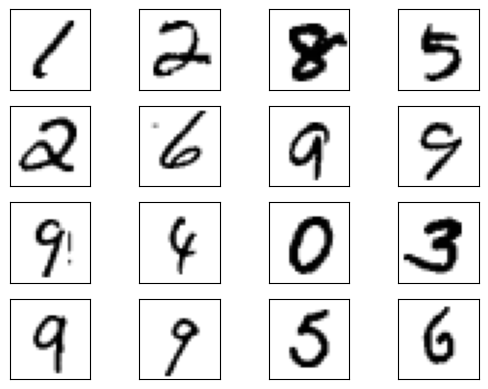

In [10]:
# Plot some training samples

real_samples, mnist_labels = next(iter(train_loader))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap = "gray_r")
    plt.xticks([])
    plt.yticks([])

In [11]:
# Implementing the discriminator
# Increasing number of neurons in each layer can help capture more complex relationships.
# We can think of it as a hyperparameter that if too high may lead to overfitting (it increases the number of param).
# Discriminator provides the probability of the image belonging to the real training data
class Discriminator(nn.Module): # Use MLP nn
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            
            nn.Linear(784, 1024), # Vectorized input 784 = 28*28, vectors with 784 coeff
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid(), # Binary classification --> 1 belongs to the real training data, 0 it doesn't belong
        )
        
    def forward(self, x):
        x = x.view(x.size(0), 784) # vectorization of input vector coeff. x size goes from (32 * 1 * 28 * 28) to (32 * 1 * 784)
        output = self.model(x)
        return output

# use device for discriminator class (GPU)
discriminator = Discriminator().to(device = device)

In [12]:
# since generator will generate more complex data, we increase the dimensions of the input from the latent space
# convert it then to 784
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            
            nn.Linear(100, 256),
            nn.ReLU(),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            
            nn.Linear(512, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 784),
            nn.Tanh(), # output coeff should be between -1 to 1
        )
        
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28) # Transform the image back to its original structure size
        return output
    
generator = Generator().to(device = device)

In [13]:
# Defining training parameters

lr = 0.0001 # decrease lr to get better result
num_epochs = 50 # set num of epochs to 50 to reduce train time (leveraging of the small lr)
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = lr)

In [14]:
# Training process
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training discriminator
        real_samples = real_samples.to(device = device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device = device)
        
        latent_space_samples = torch.randn((batch_size, 100)).to(device = device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device = device)
        
        all_samples = torch.cat(
            (real_samples, generated_samples)
        )
        
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        
        # Training discriminator
        discriminator.zero_grad() # clear gradient
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device = device)
        
        # Training generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch}, Loss in D: {loss_discriminator}")
            print(f"Epoch: {epoch}, Loss in G: {loss_generator}")
        

Epoch: 0, Loss in D: 0.5394869446754456
Epoch: 0, Loss in G: 0.5199116468429565
Epoch: 1, Loss in D: 0.060836128890514374
Epoch: 1, Loss in G: 4.084311008453369
Epoch: 2, Loss in D: 0.05133127421140671
Epoch: 2, Loss in G: 5.3691511154174805
Epoch: 3, Loss in D: 0.004378290846943855
Epoch: 3, Loss in G: 6.844546318054199
Epoch: 4, Loss in D: 0.02002742886543274
Epoch: 4, Loss in G: 4.590653419494629
Epoch: 5, Loss in D: 0.04949714615941048
Epoch: 5, Loss in G: 4.774106025695801
Epoch: 6, Loss in D: 0.03829621151089668
Epoch: 6, Loss in G: 4.946773529052734
Epoch: 7, Loss in D: 0.09926877915859222
Epoch: 7, Loss in G: 2.852358341217041
Epoch: 8, Loss in D: 0.20500966906547546
Epoch: 8, Loss in G: 2.2317428588867188
Epoch: 9, Loss in D: 0.2620392143726349
Epoch: 9, Loss in G: 2.145796060562134
Epoch: 10, Loss in D: 0.19875475764274597
Epoch: 10, Loss in G: 2.1928625106811523
Epoch: 11, Loss in D: 0.43179425597190857
Epoch: 11, Loss in G: 2.5750813484191895
Epoch: 12, Loss in D: 0.1951842

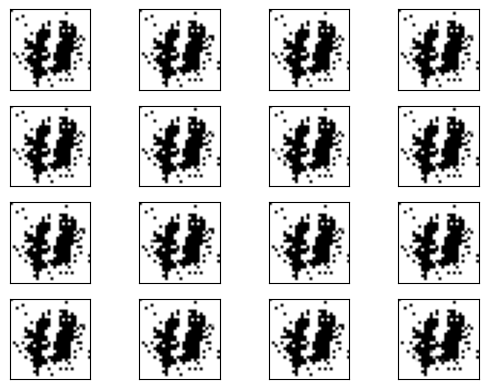

In [19]:
# Checking samples generated by the GAN
latent_space_samples = torch.randn(batch_size, 100).to(device = device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])